# Predicting Mortality in Heart Failure Patients admitted to ICU

**Jack B. Huber, Ph.D.**<br>
Senior Clinical Data Analyst<br>
Providence Swedish Pharmacy<br>
Seattle, WA<br>

[jack.huber@swedish.org](jack.huber@swedish.org)<br>
[jack.bernard.huber@gmail.com](jack.bernard.huber@gmail.com)<br>

---
## Introduction

Heart failure (HF) is a leading cause of hospitalization and readmission among United States adults.[1] Although outcomes for HF patients have improved over time, those who are hospitalized with HF are still at significant risk of mortality.[1] HF is among the top reasons for cardiac intensive care, and the prevalence of HF is increasing in CICU populations.[1]

These facts underscore ongoing need for research on the factors that predict mortality in this patient population. As one researcher recently suggested, factors predicting mortality in this population and setting remain "poorly characterized."[2] As a result, recent studies have used machine learning to predict mortality after considering the values on a range of features.[1,2,3,4]

One important but understudied dimension of this issue is gender. Does gender predict mortality? Are men or women with HF more likely to die in intensive care? If so, does this relationship depend on age? What are the implications for medical practice and prevention? Parissis et al. (2012) conducted a multivariate analysis of data on 4,953 HF patients drawn from a global registry.[5] They found that female HF patients were, relative to male patients, under-treated and under-represented in clinical trials.[5] The authors "documented the existence of differences in clinical characteristics, co-morbidities, precipitating factors, and therapeutic modalities between male and female patients admitted with AFH (acute heart failure). Despite the variety of the above factors, the length of in-hospital stay and the in-hospital mortality were similar in both genders."[5] While that study shed significant light on the topic, it was limited in not examining the interaction between gender and age.

This study aims to shed further light on this topic by examining the interactions between gender and age in mortality in the ICU among patients with HF. I will use multivariate methods to isolate the effects of gender, age, and their interaction on mortality controlling for pre-existing differences in comorbidities and vital signs. Based on data from the Centers for Disease Control,[6,7] I hypothesize that, all else equal, men with HF will be more likely to die in the ICU than women, and the effect of gender on mortality will depend on age.

This study has implications for medical practice and prevention. A clearer picture of the related mortality risks of both gender and age could help cardiologists and critical care providers tailor care to the needs of specific patients. The general public also stands to benefit from the findings of this study; data suggesting that men are more likely than women to die of HF at a younger age could prompt men to be more proactive about preventing HF from a younger age.

---
## Methods

### Data Source

The data for this study come from Zhou et al. (2021)[5] available [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.0p2ngf1zd) at [Dryad](https://datadryad.org/stash/about), "an open data publishing platform and a community committed to the open availability and routine re-use of all research data." This dataset includes 49 fields for demographic characteristics, vital signs, and laboratory values on 1,177 adult HF patients. The dataset is a sample of patient-level medical data from the larger [MIMIC-III Clinical Database](https://physionet.org/content/mimiciii/1.4/), "a publicly available critical care database containing de-identified data on 46,520 patients and 58,976 admissions to the ICU of the Beth Israel Deaconess Medical Center, Boston, USA, between 1 June, 2001 and 31 October, 2012."[8,9,10] This dataset is useful because it contains a large number of diverse patient-level variables which facilitates multivariate analysis.

### Measures

The outcome measure of all-cause hospital mortality is a binary variable in which a value 1 indicates death and 0 alive. Demographic characteristics include gender (dichotomized as 1 for men and 0 for all others), age (in years at ICU admission), and an interaction term of the two (gender x age). Comorbidities include body mass index (BMI), hypertensive, atrial fibrillation, chronic heart disease (CHD) with no myocardial infarction (MI), diabetes, deficiency anemias, depression, hyperlipemia, renal failure, and COPD, and these are all coded as binary variables in which a value of 1 indicates presence of the condition and 0 indicates absence of the condition. Vital signs include heart rate, systolic blood pressure, diastolic blood pressure, respiratory rate, temperature, oxygen saturation, and urine output.

### Data Analysis

I will use multivariate logistic regression to regress mortality on the demographic characteristics, comorbidities, and vital signs with a focus on the adjusted odds ratios for gender, age, and the gender\*age interaction. These values will illuminate the change in the logs odds of dying associated with being male, older, and older male, controlling for the other measures of comorbidities, vital signs and laboratory values.

### Data Preparation

In [ ]:
# -------------------- IMPORT LIBRARIES --------------------
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

# -------------------- LOAD RAW DATA --------------------
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fileDownloaded = drive.CreateFile({"id":"1JwgKVFFYLk3CuH7UlxjvVG3if8Zzs8EG"})
fileDownloaded.GetContentFile("data01.csv")
d = pd.read_csv("data01.csv") # these data load from the working directory but the source data come from here: https://datadryad.org/stash/dataset/doi:10.5061/dryad.0p2ngf1zd

#https://drive.google.com/file/d/1JwgKVFFYLk3CuH7UlxjvVG3if8Zzs8EG/view?usp=sharing
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#path = "https://drive.google.com/file/d/1JwgKVFFYLk3CuH7UlxjvVG3if8Zzs8EG/view?usp=sharing"
#d = pd.read_csv(path)



# -------------------- SELECT COLUMNS --------------------
data = d.loc[:,["outcome",
     "gendera",
     "age",
     "BMI",
     "hypertensive",
     "Hyperlipemia",
     "atrialfibrillation",
     "CHD with no MI",
     "COPD",
     "diabetes",
     "deficiencyanemias",
     "depression",
     "Renal failure",
     "heart rate",
     "Systolic blood pressure",
     "Diastolic blood pressure",
     "Respiratory rate",
     "temperature",
     "SP O2",
     "Urine output"]]

# -------------------- RENAME COLUMNS --------------------
data.rename(columns={"outcome":"Mortality",
                    "gendera":"Gender",
                    "age":"Age",
                    "hypertensive":"Hypertensive",
                    "hyperlipemia":"Hyperlipemia",
                    "atrialfibrillation":"Atrial_fibrillation",
                    "CHD with no MI":"CHD_no_MI",
                    "diabetes":"Diabetes",
                    "deficiencyanemias":"Deficiency_anemias",
                    "depression":"Depression",
                    "Renal failure":"Renal_failure",
                    "heart rate":"Heart_rate",
                    "Systolic blood pressure":"Systolic_BP",
                    "Diastolic blood pressure":"Diastolic_BP",
                    "Respiratory rate":"Respiratory_rate",
                    "temperature":"Temperature",
                    "SP O2":"SpO2",
                    "Urine output":"Urine_output"}, inplace=True)

# -------------------- RECODE VARIABLES --------------------
data['Male'] = data['Gender'] # ----- Dummy variable for male
def recode(series):
    if series == 2:
        return 1
    else:
        return 0
data['Male'] = data['Male'].apply(recode)

data['Male*Age'] = data['Male']*data['Age'] # ----- Male x Age interaction term

def recode(genders): # ----- Gender with labels
    if genders == 1:
        return 'Female'
    else:
        return "Male"
data['Gender'] = data['Gender'].apply(recode)

def recode(death): # ----- Mortality with labels
    if death == 0:
        return 'Alive'
    else:
        return 'Deceased'
data['Death'] = data['Mortality'].apply(recode)

# -------------------- INSPECT THE DATA FRAME --------------------
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mortality            1176 non-null   float64
 1   Gender               1177 non-null   object 
 2   Age                  1177 non-null   int64  
 3   BMI                  962 non-null    float64
 4   Hypertensive         1177 non-null   int64  
 5   Hyperlipemia         1177 non-null   int64  
 6   Atrial_fibrillation  1177 non-null   int64  
 7   CHD_no_MI            1177 non-null   int64  
 8   COPD                 1177 non-null   int64  
 9   Diabetes             1177 non-null   int64  
 10  Deficiency_anemias   1177 non-null   int64  
 11  Depression           1177 non-null   int64  
 12  Renal_failure        1177 non-null   int64  
 13  Heart_rate           1164 non-null   float64
 14  Systolic_BP          1161 non-null   float64
 15  Diastolic_BP         1161 non-null   f

,Mortality,Gender,Age,BMI,Hypertensive,Hyperlipemia,Atrial_fibrillation,CHD_no_MI,COPD,Diabetes,...,Heart_rate,Systolic_BP,Diastolic_BP,Respiratory_rate,Temperature,SpO2,Urine_output,Male,Male*Age,Death
0,0.0,Female,72,37.588179,0,1,0,0,0,1,...,68.837838,155.866667,68.333333,16.621622,36.714286,98.394737,2155.0,0,0,Alive
1,0.0,Male,75,NaN,0,0,0,0,1,0,...,101.370370,140.000000,65.000000,20.851852,36.682540,96.923077,1425.0,1,75,Alive
2,0.0,Male,83,26.572634,0,0,0,0,0,0,...,72.318182,135.333333,61.375000,23.640000,36.453704,95.291667,2425.0,1,83,Alive
3,0.0,Male,43,83.264629,0,0,0,0,0,0,...,94.500000,126.400000,73.200000,21.857143,36.287037,93.846154,8760.0,1,43,Alive
4,0.0,Male,75,31.824842,1,0,0,0,1,0,...,67.920000,156.560000,58.120000,21.360000,36.761905,99.280000,4455.0,1,75,Alive


---
## Results

Table 1[10] presents descriptive information about sample characteristics. Approximately 13.6 percent of the 1,177 patients died. The statistically significant predictors of mortality are age, atrial fibrillation, deficiency anemias, depression, hypertension, and renal failure.

In [ ]:
# -------------------- TABLE 1: DEMOGRAPHIC CHARACTERISTICS --------------------
!pip install tableone
from tableone import TableOne
#from TableOne import TableOne

t1_columns = ['Death','Gender', 'Age', 'BMI', 'Atrial_fibrillation', 'CHD_no_MI', 'COPD', 'Diabetes', 'Deficiency_anemias', 'Depression', 'Hyperlipemia', 'Hypertensive', 'Renal_failure',
             'Heart_rate','Systolic_BP','Diastolic_BP','Respiratory_rate','Temperature','SpO2','Urine_output']
t1_categorical = ['Gender', 'Atrial_fibrillation' , 'CHD_no_MI', 'COPD', 'Diabetes', 'Deficiency_anemias', 'Depression', 'Hyperlipemia', 'Hypertensive', 'Renal_failure']
t1_groupby = ['Death']
#t1_nonnormal = ['Age']
#t1_labels={'death': 'mortality'}
#t1 = TableOne(data, columns=t1_columns, categorical=t1_categorical, groupby=t1_groupby, nonnormal=nonnormal, rename=labels, pval=False)
t1 = TableOne(data, columns=t1_columns, categorical=t1_categorical, groupby=t1_groupby, pval=True)
print()
print("Table 1: Sample Characteristics")
t1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Table 1: Sample Characteristics


Grouped by Death                                                           
                                            Missing          Overall            Alive         Deceased P-Value
n                                                               1177             1017              160        
Gender, n (%)               Female                0       559 (47.5)       478 (47.0)        81 (50.6)   0.442
                            Male                          618 (52.5)       539 (53.0)        79 (49.4)        
Age, mean (SD)                                    0      74.1 (13.4)      73.7 (13.4)      76.3 (13.2)   0.023
BMI, mean (SD)                                  215       30.2 (9.3)       30.4 (9.2)       28.6 (9.9)   0.070
Atrial_fibrillation, n (%)  0                     0       646 (54.9)       578 (56.8)        68 (42.5)   0.001
                            1                             531 (45.1)       439 (43.2)        92 (57.5)        
CHD_no_MI, n (%)            0                     0      1076 (91.4)       928 (91.2)       148 (92.5)   0.709
                            1                              101 (8.6)         89 (8.8)         12 (7.5)        
COPD, n (%)                 0                     0      1088 (92.4)       935 (91.9)       153 (95.6)   0.139
                            1                               89 (7.6)         82 (8.1)          7 (4.4)        
Diabetes, n (%)             0                     0       681 (57.9)       579 (56.9)       102 (63.7)   0.124
                            1                             496 (42.1)       438 (43.1)        58 (36.2)        
Deficiency_anemias, n (%)   0                     0       778 (66.1)       653 (64.2)       125 (78.1)   0.001
                            1                             399 (33.9)       364 (35.8)        35 (21.9)        
Depression, n (%)           0                     0      1037 (88.1)       888 (87.3)       149 (93.1)   0.048
                            1                             140 (11.9)       129 (12.7)         11 (6.9)        
Hyperlipemia, n (%)         0                     0       730 (62.0)       620 (61.0)       110 (68.8)   0.072
                            1                             447 (38.0)       397 (39.0)        50 (31.2)        
Hypertensive, n (%)         0                     0       332 (28.2)       274 (26.9)        58 (36.2)   0.019
                            1                             845 (71.8)       743 (73.1)       102 (63.7)        
Renal_failure, n (%)        0                     0       747 (63.5)       625 (61.5)       122 (76.2)  <0.001
                            1                             430 (36.5)       392 (38.5)        38 (23.8)        
Heart_rate, mean (SD)                            13      84.6 (16.0)      83.8 (16.0)      89.8 (15.2)  <0.001
Systolic_BP, mean (SD)                           16     118.0 (17.4)     118.9 (17.3)     112.2 (16.6)  <0.001
Diastolic_BP, mean (SD)                          16      59.5 (10.7)      59.9 (10.9)       57.2 (8.9)   0.001
Respiratory_rate, mean (SD)                      13       20.8 (4.0)       20.6 (3.9)       22.0 (4.4)  <0.001
Temperature, mean (SD)                           19       36.7 (0.6)       36.7 (0.6)       36.5 (0.7)   0.006
SpO2, mean (SD)                                  13       96.3 (2.3)       96.3 (2.1)       95.9 (3.1)   0.064
Urine_output, mean (SD)                          36  1899.3 (1272.4)  1986.9 (1271.2)  1346.0 (1136.6)  <0.001

Figure 1 aims to offer a closer look at the relationships among gender, age, and mortality. The visual differences are not striking, so these relationships are subtle. Male patients do appear to live longer than female patients.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Figure 1: Bar Chart of Gender, Age, and Mortality



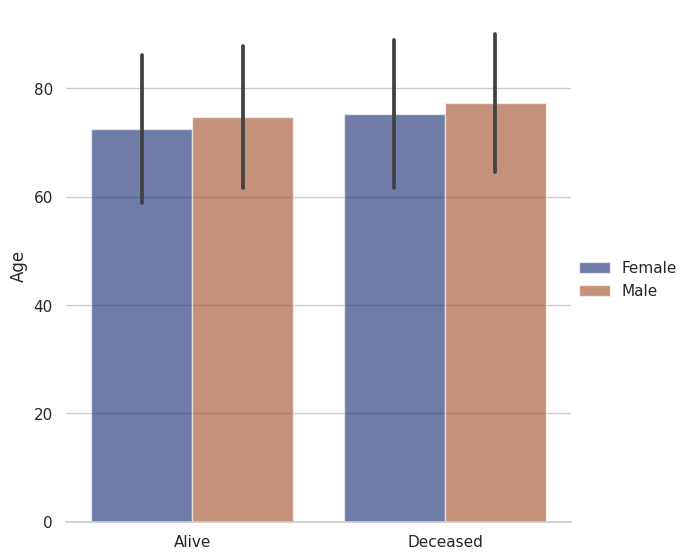

In [ ]:
# -------------------- FIGURE 1. BAR CHART --------------------
import matplotlib.pyplot as plt
import seaborn as sns
print()
print('Figure 1: Bar Chart of Gender, Age, and Mortality')
print()
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=data, kind="bar",
    x="Death", y="Age", hue="Gender",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Age")
g.legend.set_title("")

Although gender was not a significant predictor of mortality in Table 1, and no relationship between gender, age and mortality is apparent from Figure 1, it is possible that this relationship is suppressed, and depends on other variables. To explore this possibility, I specify and estimate a logistic regression model.

In [ ]:
# -------------------- TABLE 2. LOGISTIC REGRESSION --------------------

# ---------- Demographics, comorbidities, and vitals
y, X = dmatrices('Mortality ~ Male + Age + Male*Age + BMI + Atrial_fibrillation + CHD_no_MI + COPD + Diabetes + Deficiency_anemias + Depression + Hyperlipemia + Hypertensive + Renal_failure + Heart_rate + Systolic_BP + Diastolic_BP + Respiratory_rate + Temperature + SpO2 + Urine_output', data=data, return_type='dataframe')

mod = sm.Logit(y, X) # ----- Describe model
res = mod.fit() # ----- Fit model
print()
print('Table 2: Results of Logistic Regression')
print()
print(res.summary())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Optimization terminated successfully.
         Current function value: 0.295019
         Iterations 8

Table 2: Results of Logistic Regression

                           Logit Regression Results                           
Dep. Variable:              Mortality   No. Observations:                  927
Model:                          Logit   Df Residuals:                      906
Method:                           MLE   Df Model:                           20
Date:                Sat, 10 Jun 2023   Pseudo R-squ.:                  0.1948
Time:                        20:39:34   Log-Likelihood:                -273.48
converged:                       True   LL-Null:                       -339.66
Covariance Type:            nonrobust   LLR p-value:                 1.407e-18
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              33.3027      8.450      3

Table 2 reports the results of the full regression model of mortality on gender, age, the gender\*age interaction, and all comorbidities, vital signs, and laboratory values. Values in the first column are regression coefficients for each predictor and represent the average change in the log odds of mortality associated with an average change in the value of the predictor. The second column is the standard error surrounding the coefficient. The third column, the Z statistic, is the ratio of the coefficient to the standard error, and the fourth column, P>|Z|, reports the probability values of the Z statistic.

All else equal, gender, age, and the interaction between the two are not statistically significant predictors of mortality after accounting for differences in comorbidities, vital signs, and laboratory values. The only statistically significant predictors of mortality are deficiency anemias, renal failure, heart rate, diastolic blood pressure, respiratory rate, temperature, and urine output.

---
## Discussion

This study sought to model the relationships among age, gender, and mortality in a sample of data from 1,177 patients with heart failure admitted to intensive care units in the Boston area from 2001 to 2012. I hypothesized that men would be more likely to die in the ICU, and that age and gender would interact such that the effect of gender on mortality would depend on age.

The results diconfirm my hypotheses about the relationship between gender, age, and mortality. Controlling for differences in comorbidities and vital signs, gender, age, and the interaction between the two are not statistically significant predictors of mortality. This finding is consistent with the findings of Parissis et al. (2012) in their similar analysis of data from a global registry.[5]

This study is limited in three ways. The first, as mentioned previously, is the age of the data. Practice may have evolved in the 11 years since the data were collected. The second is the size of the data set. It includes data on 1,177 patients, and missing values on some variables reduced the sample size for the regression down to 927 patients; and with smaller sample sizes comes the risk of overfitting the model with too many variables. The third limitation is the data set does not include variables on medications or patient care in the ICU. Without this information it is difficult for caregivers to know how to better adapt care to the needs of specific patients.

Although this study failed to find evidence of relationships among gender, age, and mortality among HF patients in ICU settings, this line of inquiry is meritorious. Researchers and data scientists should continue to take full advantage of publicly available clinical data to isolate the factors that make the difference between life and death in the ICU.

---
## References

[1] Jentzer JC, Reddy YN, Rosenbaum AN, Dunlay SM, Borlaug BA, Hollenberg SM. Outcomes and Predictors of Mortality Among Cardiac Intensive Care Unit Patients With Heart Failure. J Card Fail. 2022;28(7):1088-1099. https://doi:10.1016/j.cardfail.2022.02.015.

[2] Li J, Liu S, Hu Y, Zhu L, Mao Y, Liu J. Predicting Mortality in Intensive Care Unit Patients With Heart Failure Using an Interpretable Machine Learning Model: Retrospective Cohort Study. J Med Internet Res. 2022;24(8):e38082. Published 2022 Aug 9. https://doi:10.2196/38082

[3] Lombardi, C., Peveri, G., Cani, D., Latta, F., Bonelli, A., Tomasoni, D., Sbolli, M., Ravera, A., Carubelli, V., Saccani, N., Specchia, C., and Metra, M. (2020) In-hospital and long-term mortality for acute heart failure: analysis at the time of admission to the emergency department. ESC Heart Failure, 7: 2650– 2661. https://doi.org/10.1002/ehf2.12847.

[4] Zhou, Jingmin et al. (2021), Prediction model of in-hospital mortality in intensive care unit patients with heart failure: machine learning-based, retrospective analysis of the MIMIC-III database, Dryad, Dataset, https://doi.org/10.5061/dryad.0p2ngf1zd.

[5] Parissis, John T., Lilian Mantziari, Nikolaos Kaldoglou, Ignatios Ikonomidis, Maria Nikolaou, Alexandre Mebazaa, Johann Altenberger et al. "Gender-related differences in patients with acute heart failure: management and predictors of in-hospital mortality." International journal of cardiology 168, no. 1 (2012): 185-189. https://doi.org/10.1016/j.ijcard.2012.09.096.

[6] Centers for Disease Control and Prevention. Men and Heart Disease. https://www.cdc.gov/heartdisease/men.htm.

[7] Centers for Disease Control and Prevention. Women and Heart Disease. https://www.cdc.gov/heartdisease/women.htm

[8] Johnson, A., Pollard, T., & Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26.

[9] Johnson, A., Pollard, T., Shen, L. et al. MIMIC-III, a freely accessible critical care database. Sci Data 3, 160035 (2016). https://doi.org/10.1038/sdata.2016.35.

[10] Goldberger A, Amaral L, Glass L, Hausdorff J, Ivanov PC, Mark R, Mietus JE, Moody GB, Peng CK, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

[11] Tom J Pollard, Alistair E W Johnson, Jesse D Raffa, Roger G Mark; tableone: An open source Python package for producing summary statistics for research papers, JAMIA Open, Volume 1, Issue 1, 1 July 2018, Pages 26–31, https://doi.org/10.1093/jamiaopen/ooy012